### Importing libs

In [1]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from heuristics.closest_neighbor import closest_neighbor
from typing import Set, List, Tuple, Dict, Any
from itertools import product
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#### Import data set

In [2]:
try:
    data_set = get_data_json("../../data/Denver/42Denver30.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 2
    Q = vehicle_capacity
    q = demands
    c = distance_matrix
except Exception as e:
    raise e

2024-09-13 11:13:01.514 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualize the distance matrix as a DataFrame

In [3]:
df = pd.DataFrame(c)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0,2206,1938,1904,1405,2161,2498,2811,1136,987,...,4585,6153,6550,7080,6650,6819,7397,9498,9650,9977
1,1757,0,269,652,802,1740,2533,3729,1176,1709,...,6276,7395,7871,8322,7892,8378,8956,11058,11209,11597
2,1489,269,0,383,533,1471,2264,3460,908,1441,...,6008,7126,7603,8053,7624,8109,8687,10789,10940,11329
3,1457,652,383,0,501,1439,2232,3428,874,1407,...,5974,7094,7570,8021,7591,8077,8655,10757,10908,11296
4,956,802,533,501,0,938,1732,2927,375,908,...,5475,6594,7070,7521,7091,7577,8155,10257,10408,10796
5,1685,1740,1471,1439,938,0,943,2641,1104,1197,...,5906,6837,7313,7764,7334,7820,8398,10500,10651,11039
6,1920,2681,2412,2380,1880,1645,0,1698,1532,1450,...,5657,6909,7385,7836,7406,7670,8248,10347,10498,10915
7,2958,3791,3522,3490,2989,3280,1698,0,2639,2189,...,5631,5391,5868,6318,5889,6400,6978,9080,9231,9612
8,692,1176,908,874,375,1025,1450,2646,0,533,...,5100,6312,6788,7239,6809,7295,7873,9975,10126,10474
9,961,1688,1419,1387,887,1178,1513,2179,539,0,...,4709,5845,6322,6772,6342,6828,7406,9508,9659,10048


#### Creating model instance

In [4]:
model = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

#### Define binary and continuous decision variables

In [5]:
x: Dict[Tuple[int, int], mip.Var] = {
    (i, j): model.add_var(name=f"x_{i}_{j}", var_type=mip.BINARY) for (i, j) in A
}

f = {
    (i, j): model.add_var(name=f"f_{i}_{j}", var_type=mip.CONTINUOUS)
    for i in V
    for j in V
}

#### Set the objective function to minimize total distance

In [6]:
model.objective = mip.minimize(mip.xsum(cost * x[i, j] for (i, j), cost in A.items()))

#### Set the m-TSP essential constraints

In [7]:
model += mip.xsum(x[i, i] for i in V) == 0

for j in V - {0}:
    model += mip.xsum(x[i, j] for i in V) == 1  # Inflow
    model += mip.xsum(x[j, i] for i in V) == 1  # Outflow

model += mip.xsum(x[0, j] for j in V - {0}) <= m  # Vehicle limit

model += (
    mip.xsum(x[0, j] for j in V - {0}) - mip.xsum(x[j, 0] for j in V - {0}) == 0
)  # All vehicles used must return to depot

#### Add flow conservation and vehicle capacity constraints

In [8]:
model += mip.xsum(f[i, i] for i in V) == 0

for j in V - {0}:
    model += (
        mip.xsum(f[j, i] for i in V if i != j) - mip.xsum(f[i, j] for i in V if i != j)
        == q[j]
    )

for i in V:
    for j in V:
        if i != j:
            flow_lower_bound = max(0, q[i], -q[j]) * x[i, j]
            flow_upper_bound = min(Q, Q + q[i], Q - q[j]) * x[i, j]

            model += f[i, j] >= flow_lower_bound
            model += f[i, j] <= flow_upper_bound

#### Generate an initial solution using closest neighbor heuristics

In [9]:
def generate_initial_solution(
    stations: Set[int],
    demands: List[int],
    distance_matrix: np.matrix,
    vehicle_capacity: int,
    x: Dict[Tuple[int, int], mip.Var],
) -> List[Tuple[mip.Var, int]]:
    depot = 0
    customers = list(stations - {depot})
    demand_dict = dict(enumerate(demands))
    routes = closest_neighbor(
        depot, customers, demand_dict, distance_matrix, vehicle_capacity
    )

    initial_solution: List[Tuple[mip.Var, int]] = []
    for route in routes:
        for i, j in zip(route, route[1:]):
            initial_solution.append((x[i, j], 1))

    return initial_solution

In [10]:
initial_solution = generate_initial_solution(V, q, c, Q, x)

#### Implement separation procedure for subtour elimination

In [11]:
class SeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        depot = 0
        y = model.translate(self.x)

        G_prime = nx.DiGraph()
        G_prime.add_nodes_from(vertices)

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for u, v in arcs_prime:
            G_prime.add_edge(u, v, capacity=y[u, v].x)

        for node in vertices - {depot}:
            flow_value, _ = nx.maximum_flow(G_prime, depot, node)

            if flow_value < 1:
                _, (S, _) = nx.minimum_cut(G_prime, depot, node)
                tour = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j and y[i, j] and i in S and j in S
                ]

                if sum(value for _, value in tour) >= (len(S) - 1) + 1e-4:
                    cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                    cut_pool.add(cut)

                total_demand = abs(sum(self.q[i] for i in S))
                min_vehicles = math.ceil(total_demand / self.Q)

                if min_vehicles < flow_value:
                    if (
                        sum(value for _, value in tour)
                        >= (len(S) - max(1, min_vehicles)) + 1e-4
                    ):
                        stronger_cut = mip.xsum(1 * var for var, _ in tour) <= len(
                            S
                        ) - max(1, min_vehicles)
                        cut_pool.add(stronger_cut)

        for cut in cut_pool.cuts:
            model += cut

In [12]:
model.start = initial_solution
model.cuts_generator = SeparationProcedure(V, A, q, Q, x)
model.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Dual Simplex

Clp0024I Matrix will be packed to eliminate 675 small elements
Coin0506I Presolve 4577 (-677) rows, 5100 (-102) columns and 19000 (-877) elements
Clp0000I Optimal - objective value 42925.06
Coin0511I After Postsolve, objective 42925.06, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 42925.05957 - 2800 iterations time 0.342, Presolve 0.01

Starting MIP optimization
Cgl0002I 51 variables fixed
Cgl0004I processed model has 4527 rows, 5050 columns (2550 integer (2550 of which binary)) and 23800 elements
Coin3009W Conflict graph built in 0.014 seconds, density: 0.245%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I Fixing only non-zero variables.
Cbc0045I Warning: mipstart values could not be used to build a solution.
Cbc0045I Nauty did not find any useful orbits in time 0.324544
Cbc0038

<OptimizationStatus.OPTIMAL: 0>

In [13]:
if model.num_solutions:
    model.check_optimization_results()

    optimal_route = [
        (origin, destination)
        for origin in V
        for destination in V
        if x[origin, destination].x == 1
    ]

    optimal_flow = [
        (origin, destination)
        for origin in V
        for destination in V
        if f[origin, destination].x and x[origin, destination].x >= 0.5
    ]

    for origin, destination in optimal_route:
        variable_name = f"x_{origin}_{destination}"
        variable_value = x[origin, destination].x
        print(f"{model.var_by_name(variable_name)} = {variable_value}")

x_0_9 = 1.0
x_0_19 = 1.0
x_1_12 = 1.0
x_2_1 = 1.0
x_3_2 = 1.0
x_4_3 = 1.0
x_5_4 = 1.0
x_6_7 = 1.0
x_7_0 = 1.0
x_8_5 = 1.0
x_9_8 = 1.0
x_10_13 = 1.0
x_11_0 = 1.0
x_12_29 = 1.0
x_13_14 = 1.0
x_14_15 = 1.0
x_15_16 = 1.0
x_16_17 = 1.0
x_17_31 = 1.0
x_18_22 = 1.0
x_19_18 = 1.0
x_20_10 = 1.0
x_21_24 = 1.0
x_22_11 = 1.0
x_23_20 = 1.0
x_24_25 = 1.0
x_25_23 = 1.0
x_26_27 = 1.0
x_27_42 = 1.0
x_28_26 = 1.0
x_29_28 = 1.0
x_30_32 = 1.0
x_31_30 = 1.0
x_32_41 = 1.0
x_33_21 = 1.0
x_34_33 = 1.0
x_35_34 = 1.0
x_36_6 = 1.0
x_37_36 = 1.0
x_38_37 = 1.0
x_39_35 = 1.0
x_40_39 = 1.0
x_41_40 = 1.0
x_42_43 = 1.0
x_43_44 = 1.0
x_44_45 = 1.0
x_45_50 = 1.0
x_46_38 = 1.0
x_47_46 = 1.0
x_48_47 = 1.0
x_49_48 = 1.0
x_50_49 = 1.0


In [14]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -2
Station 2: -4
Station 3: 1
Station 4: 1
Station 5: -3
Station 6: -2
Station 7: 1
Station 8: -2
Station 9: -3
Station 10: 2
Station 11: -8
Station 12: 1
Station 13: 3
Station 14: 2
Station 15: 4
Station 16: 1
Station 17: -1
Station 18: 1
Station 19: -7
Station 20: -4
Station 21: 1
Station 22: -5
Station 23: -3
Station 24: -6
Station 25: -6
Station 26: -6
Station 27: -1
Station 28: 7
Station 29: 1
Station 30: 5
Station 31: 1
Station 32: 1
Station 33: -4
Station 34: -1
Station 35: 3
Station 36: 2
Station 37: -2
Station 38: 3
Station 39: 1
Station 40: 3
Station 41: -2
Station 42: 3
Station 43: -2
Station 44: 1
Station 45: 2
Station 46: -2
Station 47: 1
Station 48: -2
Station 49: -4
Station 50: -5


In [15]:
print("Optimal flow between stations:")
for origin, destination in optimal_flow:
    flow_var_name = f"f_{origin}_{destination}"
    flow_value = f[origin, destination].x
    print(f"Flow from Station {origin} to Station {destination}: {flow_value}")

Optimal flow between stations:
Flow from Station 0 to Station 9: 18.0
Flow from Station 0 to Station 19: 19.0
Flow from Station 1 to Station 12: 6.0
Flow from Station 2 to Station 1: 8.0
Flow from Station 3 to Station 2: 12.0
Flow from Station 4 to Station 3: 11.0
Flow from Station 5 to Station 4: 10.0
Flow from Station 6 to Station 7: 1.0
Flow from Station 7 to Station 0: 2.0
Flow from Station 8 to Station 5: 13.0
Flow from Station 9 to Station 8: 15.0
Flow from Station 10 to Station 13: 2.0
Flow from Station 12 to Station 29: 7.0
Flow from Station 13 to Station 14: 5.0
Flow from Station 14 to Station 15: 7.0
Flow from Station 15 to Station 16: 11.0
Flow from Station 16 to Station 17: 12.0
Flow from Station 17 to Station 31: 11.0
Flow from Station 18 to Station 22: 13.0
Flow from Station 19 to Station 18: 12.0
Flow from Station 21 to Station 24: 19.0
Flow from Station 22 to Station 11: 8.0
Flow from Station 23 to Station 20: 4.0
Flow from Station 24 to Station 25: 13.0
Flow from Stati

In [16]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

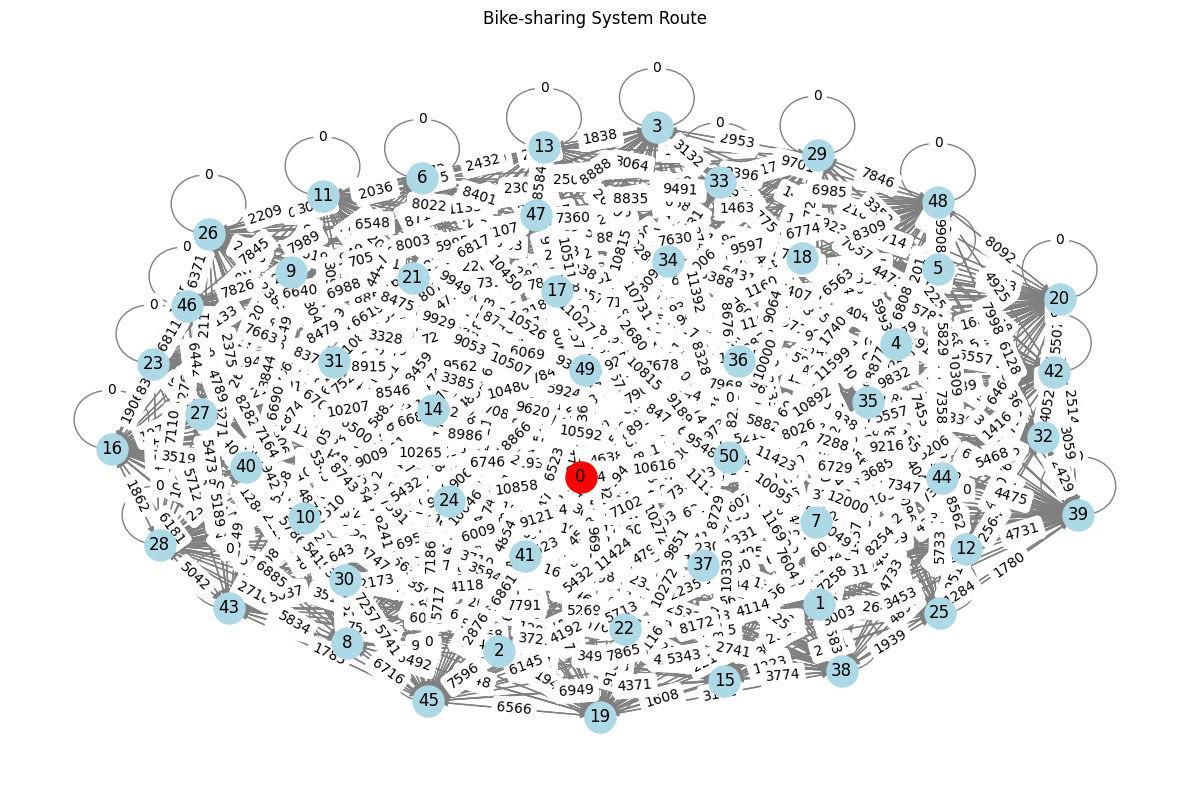

In [17]:
plot_route(V, A)

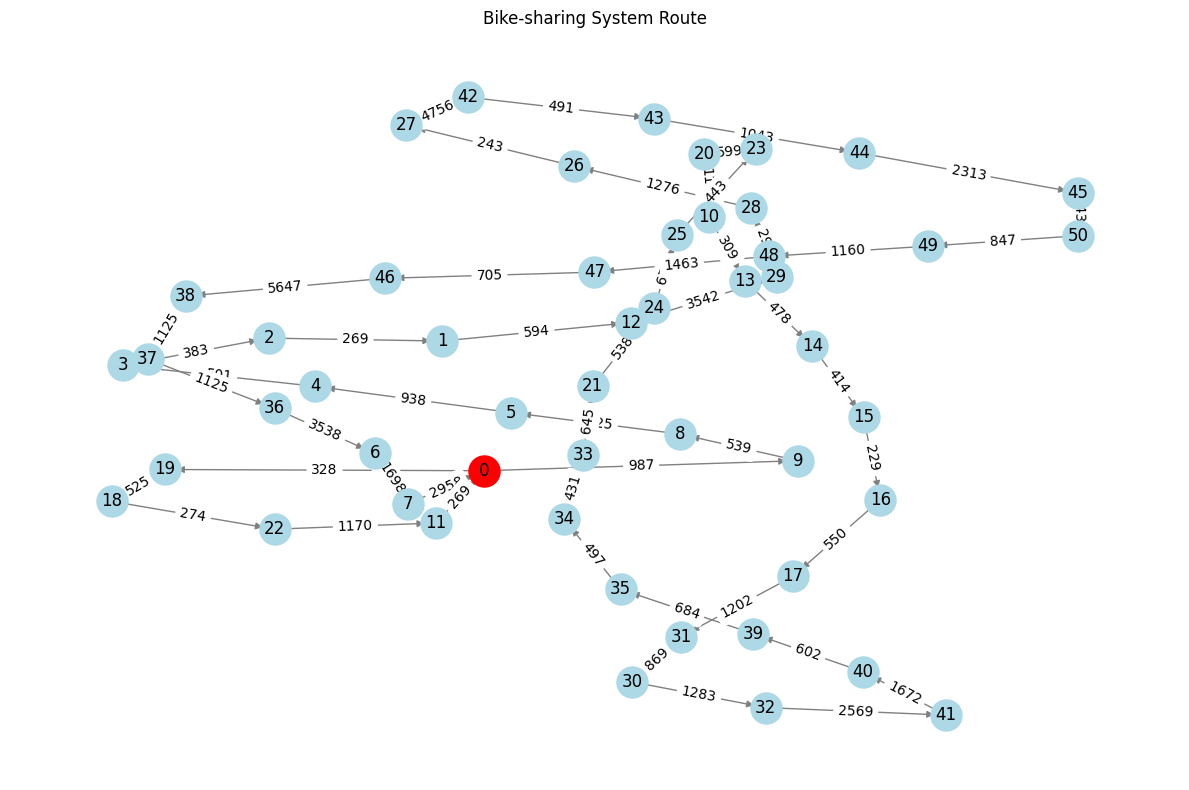

In [18]:
plot_route(V, optimal_route)